In [1]:
import os
import time, datetime
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

### FUNCTIONS

In [2]:
def is_place(result):
    return (result <= 3)*1

def plot_win_percentage(df, col, label_col, target='won'):
    
    tmp1 = df[[col, target]].groupby([col, target]).size().reset_index(name='wins')
    tmp2 = pd.DataFrame({'win_pct' : tmp1.groupby([col])['wins'].apply(lambda x: round(x / x.sum(), 2))})
    tmp3 = pd.concat([tmp1, tmp2], axis=1)
    tmp3 = tmp3[tmp3[target] == 1]

    plt.figure(figsize=(8, 6), dpi=100)
    sns.lineplot(x=tmp3[col].astype(int), y=tmp3['win_pct'])
    plt.xlabel(label_col, fontsize=14)
    plt.ylabel('win percentage', fontsize=14)
    plt.title(f'{label_col} vs win percentage')
    #plt.savefig(os.path.join('OUTPUT_PATH', '{}_pct_win.png'.format(label_col)))
    plt.show()

### DATA

In [57]:
DATA_PATH = '../input/hkracing'

df_races = pd.read_csv(os.path.join(DATA_PATH, 'races.csv'))
df_runs = pd.read_csv(os.path.join(DATA_PATH, 'runs.csv'))


df_runners = df_runs.merge(df_races, on='race_id')
df_runners['date'] = pd.to_datetime(df_races['date'])
df_runners['place'] = list(map(is_place, df_runners['result']))

In [4]:
df_runners.head(2)

,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,horse_rating,...,place_combination4,place_dividend1,place_dividend2,place_dividend3,place_dividend4,win_combination1,win_dividend1,win_combination2,win_dividend2,place
0,0,1,3917,10,0.0,8.00,3,AUS,Gelding,60,...,NaN,36.5,25.5,18.0,NaN,8,121.0,NaN,NaN,0
1,0,2,2157,8,0.0,5.75,3,NZ,Gelding,60,...,NaN,36.5,25.5,18.0,NaN,8,121.0,NaN,NaN,0


### STATISTICS

In [5]:
print(f"Number of races : {df_runners.race_id.nunique()}")
print(f"Number of different horses : {df_runners.horse_id.nunique()}")
print(f"Number of different jockeys : {df_runners.jockey_id.nunique()}")
print(f"Number of different trainers : {df_runners.trainer_id.nunique()}")
print(f"Number of races' place : {df_runners.venue.nunique()}")
print(f"Data Period covered from {df_runners.date.min()} to {df_runners.date.max()}")
print(f"Number of different countries : {df_runners.horse_country.nunique()}")
print(f"Most dominant country : {df_runners.horse_country.mode()[0]}")
print(f"Most dominant horse type : {df_runners.horse_type.mode()[0]}")
print(f"Total high races run by a horse : {df_runners.horse_id.value_counts()[0]}")

Number of races : 6348
Number of different horses : 4405
Number of different jockeys : 186
Number of different trainers : 176
Number of races' place : 2
Data Period covered from 1997-06-02 00:00:00 to 2005-08-28 00:00:00
Number of different countries : 16
Most dominant country : AUS
Most dominant horse type : Gelding
Total high races run by a horse : 39


### MISSING VALUES

In [40]:
features_with_missing_values = df_runners.columns[df_runners.isna().sum(axis=0) > 0]
print(f"There is {len(features_with_missing_values)} features with missing values among the {df_runners.shape[1]} variables")

There is 30 features with missing values among the 81 variables


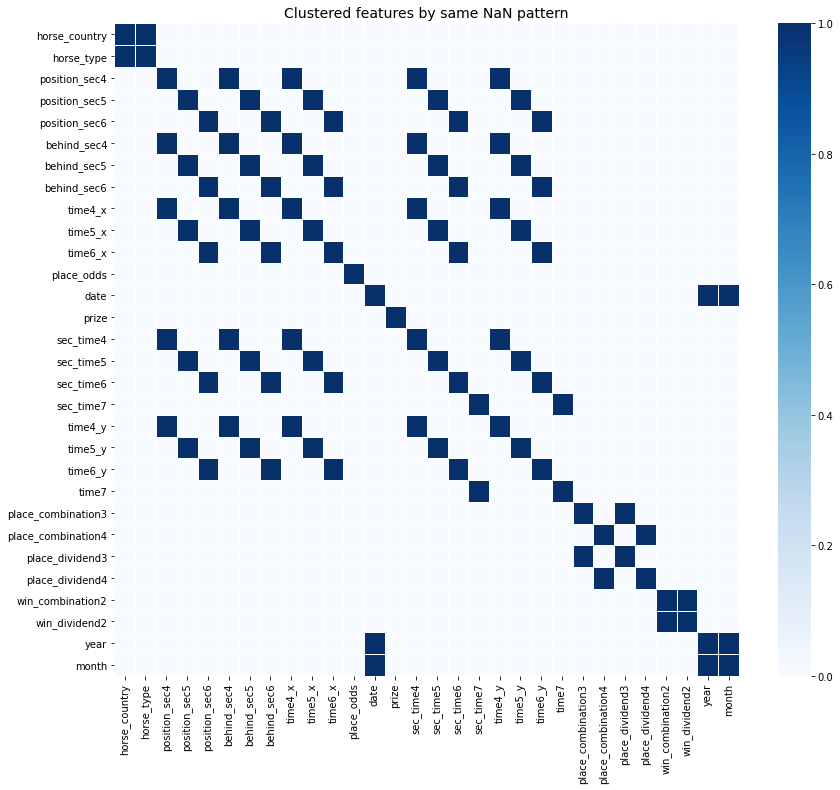

In [42]:
temp = df_runners[features_with_missing_values].isna()
temp = temp.astype(int).values

n = np.zeros((len(features_with_missing_values), len(features_with_missing_values)))
for i in (range(len(features_with_missing_values))):
    for j in range(len(features_with_missing_values)):
        n[i, j] = (temp[:, i]==temp[:, j]).all()

del temp

n  = pd.DataFrame(columns = features_with_missing_values, data=n, index= features_with_missing_values)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,12))
sns.heatmap(n, cmap='Blues', linewidths=.5,)
ax.set_title('Clustered features by same NaN pattern', fontsize=14)
plt.show()

- More than 90% of race date are missing 

### ADDITIONAL FEATURES

In [58]:
def add_time_features(df):
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    
    return df

df_runners = add_time_features(df_runners)
df_runners['horse_under_4'] = df_runners['horse_age'].apply(lambda a: 1 if a <= 4 else 0)

df_runners_per_race = df_runners[['race_id', 'horse_no']].groupby('race_id').size().reset_index(name='number_of_runners')
df_runners_age = df_runners[['race_id', 'horse_under_4']].groupby('race_id').sum().reset_index().rename(columns={'horse_under_4':'number_of_runners_under_4'})

df_runners = df_runners.merge(df_runners_per_race, on='race_id')
df_runners = df_runners.merge(df_runners_age, on='race_id')

df_runners['ratio_runners_under_4'] = df_runners['number_of_runners_under_4'] / df_runners['number_of_runners']

### DATA DISTRIBUTION

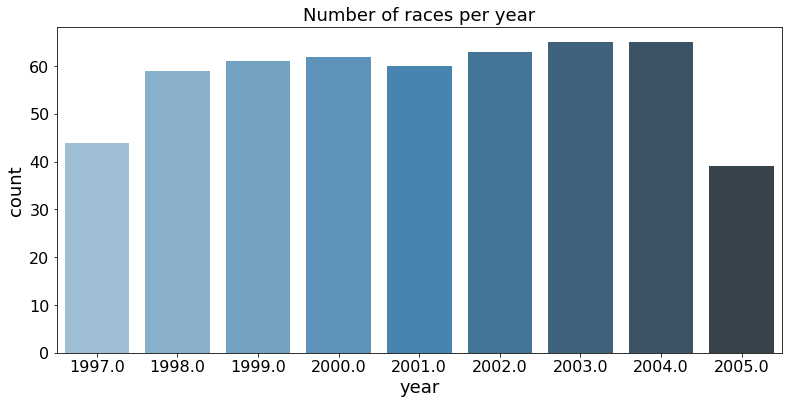

In [7]:
fig, ax = plt.subplots(figsize = (13, 6))
sns.countplot(x = df_runners.drop_duplicates(subset=['race_id', 'year'], keep='first')['year'], palette='Blues_d')
   
plt.title('Number of races per year', fontsize=18)
plt.xlabel('year', fontsize=18)
plt.ylabel('count', fontsize=18)
plt.xticks(fontsize=16, rotation=0)
plt.yticks(fontsize=16)
plt.savefig('year_distribution.png')
plt.show()

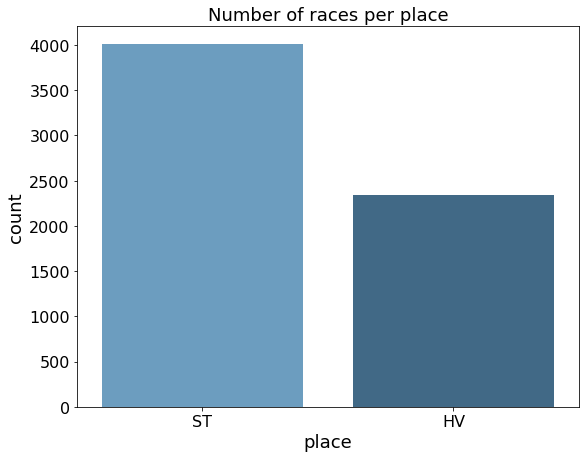

In [8]:
fig, ax = plt.subplots(figsize = (9, 7))
sns.countplot(x = df_runners.drop_duplicates(subset=['race_id', 'venue'], keep='first')['venue'], palette='Blues_d')
   
plt.title('Number of races per place', fontsize=18)
plt.xlabel('place', fontsize=18)
plt.ylabel('count', fontsize=18)
plt.xticks(fontsize=16, rotation=0)
plt.yticks(fontsize=16)
plt.savefig('hippo_distribution.png')
plt.show()

### TARGET DISTRIBUTION

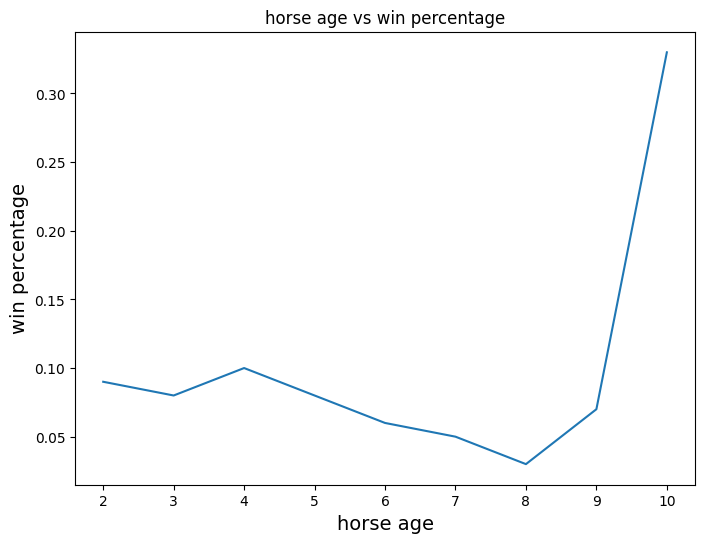

In [9]:
plot_win_percentage(df_runners, 'horse_age', 'horse age')

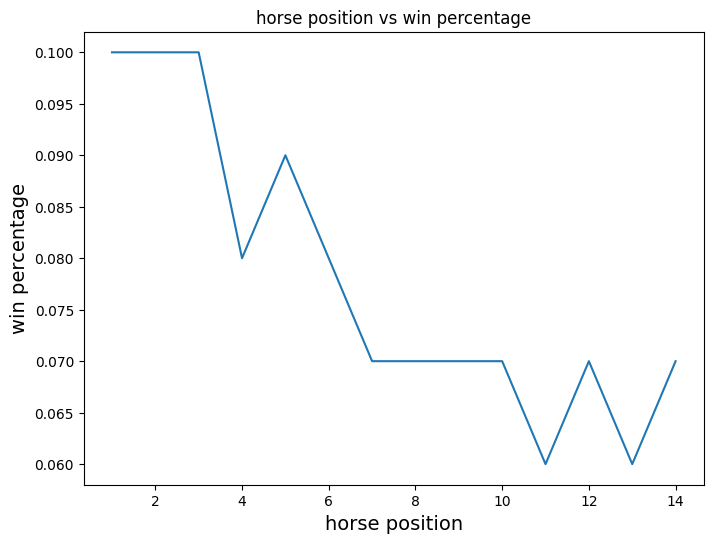

In [10]:
plot_win_percentage(df_runners, 'draw', 'horse position')

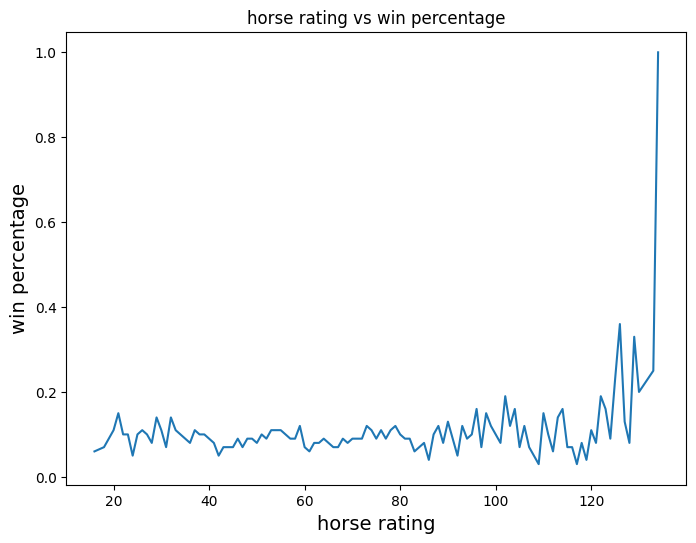

In [11]:
plot_win_percentage(df_runners, 'horse_rating', 'horse rating')

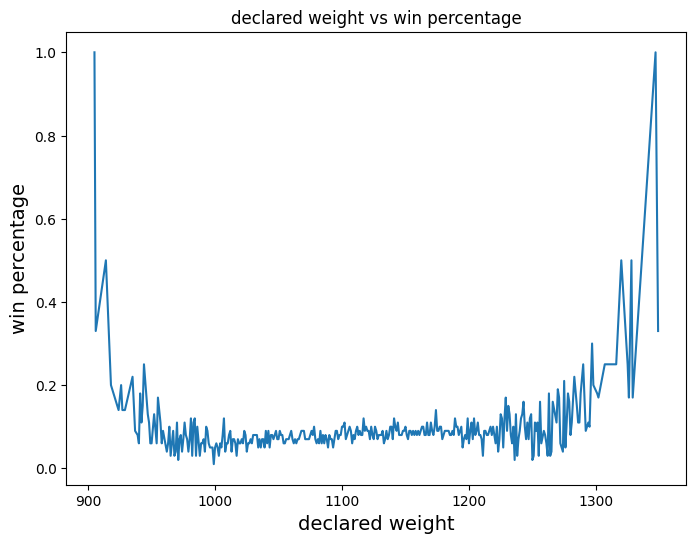

In [12]:
plot_win_percentage(df_runners, 'declared_weight', 'declared weight')

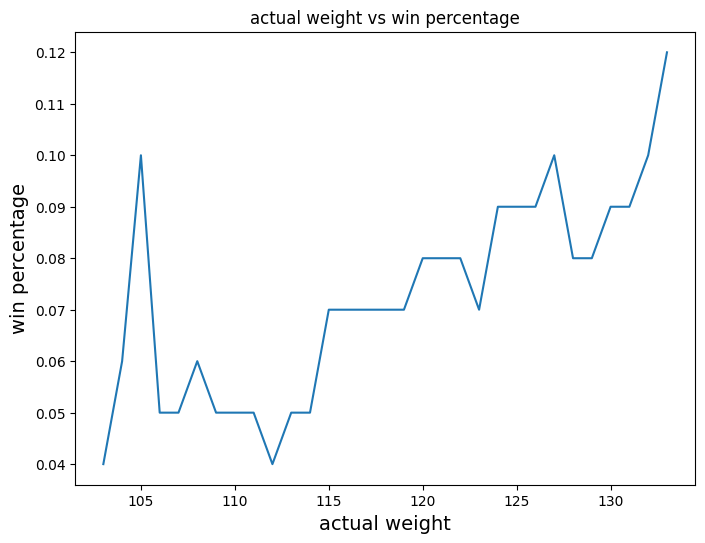

In [13]:
plot_win_percentage(df_runners, 'actual_weight', 'actual weight')

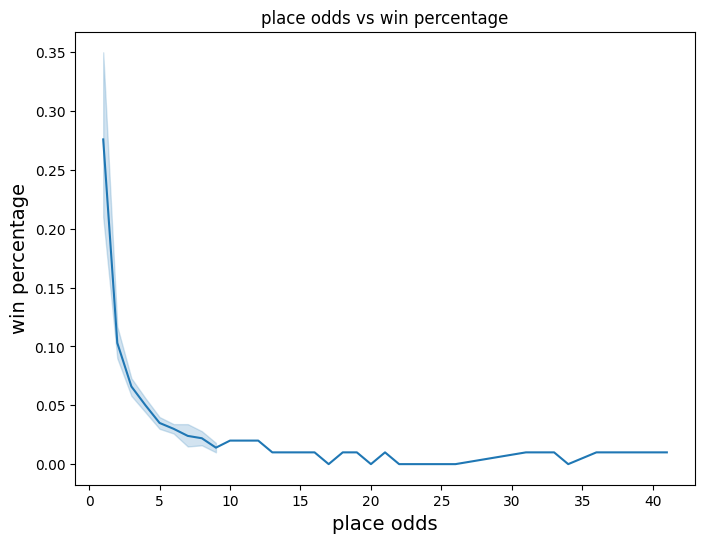

In [14]:
plot_win_percentage(df_runners, 'place_odds', 'place odds')

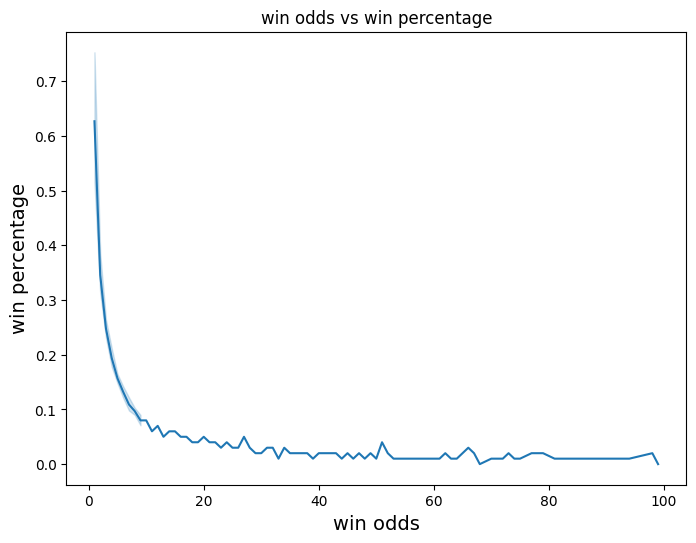

In [15]:
plot_win_percentage(df_runners, 'win_odds', 'win odds')

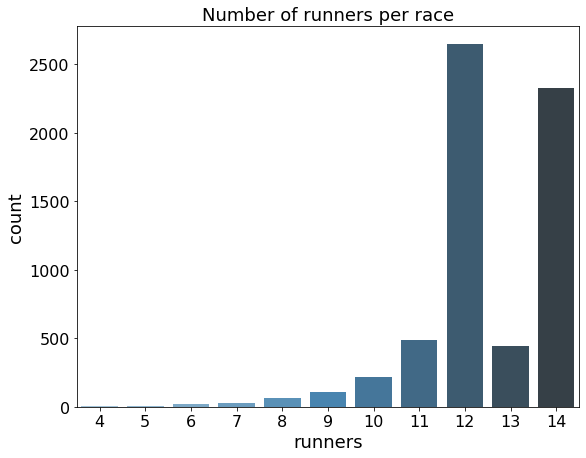

In [16]:
fig, ax = plt.subplots(figsize = (9, 7))
sns.countplot(x = df_runners_per_race['number_of_runners'], palette='Blues_d')
   
plt.title('Number of runners per race', fontsize=18)
plt.xlabel('runners', fontsize=18)
plt.ylabel('count', fontsize=18)
plt.xticks(fontsize=16, rotation=0)
plt.yticks(fontsize=16)
plt.show()

In [17]:
df_runners['number_of_runners'].value_counts(normalize=True)

14    0.409707
12    0.399361
13    0.072489
11    0.067982
10    0.027188
9     0.012348
8     0.006545
7     0.002467
6     0.001510
5     0.000252
4     0.000151
Name: number_of_runners, dtype: float64

### TRAINER

In [18]:
df_runners[['race_id', 'trainer_id']].groupby('trainer_id').size().reset_index(name='trainer_runs').describe()

,trainer_id,trainer_runs
count,176.000000,176.000000
mean,87.500000,451.403409
std,50.950957,1138.320890
min,0.000000,1.000000
25%,43.750000,1.000000
50%,87.500000,2.000000
75%,131.250000,5.250000
max,175.000000,4739.000000


- 75% of trainers participate in less than 5 races

### JOCKEY

In [19]:
df_runners[['race_id', 'jockey_id']].groupby('jockey_id').size().reset_index(name='jockey_runs').describe()

,jockey_id,jockey_runs
count,186.000000,186.000000
mean,92.500000,427.134409
std,53.837719,935.997135
min,0.000000,1.000000
25%,46.250000,2.000000
50%,92.500000,10.500000
75%,138.750000,240.250000
max,185.000000,4719.000000
